<a href="https://colab.research.google.com/github/always-newbie161/probml-notebooks/blob/jax_vdvae/notebooks/vdvae_jax_cifar_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows demo working with vdvae in jax and the code used is from [vdvae-jax](https://github.com/j-towns/vdvae-jax) from [Jamie Townsend](https://j-towns.github.io/)

## Setup

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
project_id = "probml"
!gcloud config set project {project_id}

Updated property [core/project].


In [14]:
"""
this should be the format of the checkpoint filetree:
  checkpoint_path >> model(optimizer)_checkpoint_file.
  checkpoint_path_ema >> ema_checkpoint_file
"""
checkpoint_path = "/content/vdvae_cifar10_2.86/latest_cifar10"

# checkpoints are downloaded at these paths.
#  vdvae_cifar10_2.86/latest_cifar10 - optimizer+mode
#  vdvae_cifar10_2.86/latest_cifar10_ema - ema_params'

'vdvae_cifar10_2.86/latest_cifar10 - optimizer+mode\nvdvae_cifar10_2.86/latest_cifar10_ema - ema_params'

In [13]:
# @title Download checkpoints
!gsutil cp -r gs://gsoc_bucket/vdvae_cifar10_2.86 ./
!ls -l /content/vdvae_cifar10_2.86/latest_cifar10
!ls -l /content/vdvae_cifar10_2.86/latest_cifar10_ema

Copying gs://gsoc_bucket/vdvae_cifar10_2.86/latest_cifar10/checkpoint_770000...
Copying gs://gsoc_bucket/vdvae_cifar10_2.86/latest_cifar10_ema/checkpoint_770000...
| [2 files][597.5 MiB/597.5 MiB]                                                
Operation completed over 2 objects/597.5 MiB.                                    


In [15]:
!git clone https://github.com/j-towns/vdvae-jax.git

Cloning into 'vdvae-jax'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 35 (delta 12), reused 15 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [16]:
%cd vdvae-jax

/content/vdvae-jax


In [17]:
!pip install --quiet flax

     |████████████████████████████████| 183 kB 5.4 MB/s 
     |████████████████████████████████| 118 kB 39.8 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 


In [18]:
import os

try:
    os.environ["COLAB_TPU_ADDR"]
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
except:
    pass

In [19]:
import jax

jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Model
(for cifar10)

### Setting up hyperparams

In [22]:
from hps import HPARAMS_REGISTRY, Hyperparams, add_vae_arguments
from train_helpers import setup_save_dirs
import argparse
import dataclasses

H = Hyperparams()
parser = argparse.ArgumentParser()
parser = add_vae_arguments(parser)
parser.set_defaults(hps="cifar10", conv_precision="highest")

H = dataclasses.replace(H, **vars(parser.parse_args([])))
hparam_sets = [x for x in H.hps.split(",") if x]
for hp_set in hparam_sets:
    hps = HPARAMS_REGISTRY[hp_set]
    parser.set_defaults(**hps)

H = dataclasses.replace(H, **vars(parser.parse_args([])))
H = setup_save_dirs(H)

This model is a hierarchical model with multiple stochastic blocks with multiple deterministic layers. You can know about model skeleton by observing the encoder and decoder "strings"

**How to understand the string:**
*   blocks are comma seperated 
*   `axb` implies there are `b` res blocks(set of Conv layers) for dimensions `axa`
*  `amb` implies it is a mixin block which increases the inter-image dims from `a` to `b` using **nearest neighbour upsampling** (used in decoder)
* `adb` implies it's a block with avg-pooling layer which reduces the dims from `a` to `b`(used in encoder)

for more understanding refer to this [paper](https://arxiv.org/abs/2011.10650)



In [23]:
hparams = dataclasses.asdict(H)
for k in ["enc_blocks", "dec_blocks", "zdim", "n_batch", "device_count"]:
    print(f"{k}:{hparams[k]}")

enc_blocks:32x11,32d2,16x6,16d2,8x6,8d2,4x3,4d4,1x3
dec_blocks:1x1,4m1,4x2,8m4,8x5,16m8,16x10,32m16,32x21
zdim:16
n_batch:16
device_count:8


In [24]:
from utils import logger
from jax.interpreters.xla import DeviceArray

log = logger(H.logdir)
if H.log_wandb:
    import wandb

    def logprint(*args, pprint=False, **kwargs):
        if len(args) > 0:
            log(*args)
        wandb.log({k: np.array(x) if type(x) is DeviceArray else x for k, x in kwargs.items()})

    wandb.init(config=dataclasses.asdict(H))
else:
    logprint = log

In [25]:
import numpy as np
from jax import lax
import torch
import imageio
from PIL import Image
import glob
from torch.utils.data import DataLoader
from torchvision import transforms


np.random.seed(H.seed)
torch.manual_seed(H.seed)
H = dataclasses.replace(
    H,
    conv_precision={"default": lax.Precision.DEFAULT, "high": lax.Precision.HIGH, "highest": lax.Precision.HIGHEST}[
        H.conv_precision
    ],
    seed_init=H.seed,
    seed_sample=H.seed + 1,
    seed_train=H.seed + 2 + H.host_id,
    seed_eval=H.seed + 2 + H.host_count + H.host_id,
)
print("training model on ", H.dataset)

training model on  cifar10


### Downloading cifar10 dataset

In [26]:
!./setup_cifar10.sh

--2021-08-18 12:11:58--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  99.4MB/s    in 1.6s    

2021-08-18 12:12:00 (99.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



### Setting up the model, data and the preprocess fn.

In [27]:
from data import set_up_data

H, data_train, data_valid_or_test, preprocess_fn = set_up_data(H)

In [28]:
from train_helpers import load_vaes

H = dataclasses.replace(H, restore_path=checkpoint_path)
optimizer, ema_params, start_epoch = load_vaes(H, logprint)

time: Wed Aug 18 12:12:58 2021, message: Restoring vae from /content/vdvae_cifar10_2.86/latest_cifar10
time: Wed Aug 18 12:13:00 2021, total_params: 39145700, readable: 39,145,700


/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [29]:
start_epoch  # no.of.epochs trained

547

In [30]:
# Hparams for the current model
hparams = dataclasses.asdict(H)
for i, k in enumerate(sorted(hparams)):
    logprint(f"type=hparam, key={k}, value={getattr(H, k)}")

time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=adam_beta1, value=0.9
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=adam_beta2, value=0.9
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=axis_visualize, value=None
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=bottleneck_multiple, value=0.25
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=conv_precision, value=HIGHEST
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=custom_width_str, value=
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=data_root, value=./
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=dataset, value=cifar10
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=dec_blocks, value=1x1,4m1,4x2,8m4,8x5,16m8,16x10,32m16,32x21
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=desc, value=test
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=device_count, value=8
time: Wed Aug 18 12:13:04 2021, message: type=hparam, key=ema

### Evaluation

In [31]:
from train import run_test_eval

run_test_eval(H, ema_params, data_valid_or_test, preprocess_fn, logprint)

evaluating
test results
n_batches 39
filtered_elbo -2.8696508
elbo -2.8696508
kl 1.4757005
log_likelihood -1.3939505
time: Wed Aug 18 12:14:42 2021, type: test_loss, n_batches: 39, filtered_elbo: -2.86965, elbo: -2.86965, kl: 1.47570, log_likelihood: -1.39395


### Function to save and show of batch of images given as a numpy array.



In [32]:
def zoom_in(fname, shape):
    im = Image.open(fname)
    resized_im = im.resize(shape)
    resized_im.save(fname)


def save_n_show(images, order, image_shape, fname, zoom=True, show=False):
    n_rows, n_images = order
    im = (
        images.reshape((n_rows, n_images, *image_shape))
        .transpose([0, 2, 1, 3, 4])
        .reshape([n_rows * image_shape[0], n_images * image_shape[1], 3])
    )
    print(f"printing samples to {fname}")
    imageio.imwrite(fname, im)

    if zoom:
        zoom_in(fname, (640, 64))  # w=640, h=64

    if show:
        display(Image.open(fname))

## Generations

In [33]:
n_images = 10
num_temperatures = 3
image_shape = [H.image_size, H.image_size, H.image_channels]
H = dataclasses.replace(H, num_images_visualize=n_images, num_temperatures_visualize=num_temperatures)

Images will be saved in the following dir

In [34]:
H.save_dir

'./saved_models/test'

As the model params are replicated over multiple devices, unreplicated copy of them is made to use it for sampling and generations.

In [35]:
from jax import random
from vae import VAE
from flax import jax_utils
from functools import partial

rng = random.PRNGKey(H.seed_sample)

ema_apply = partial(VAE(H).apply, {"params": jax_utils.unreplicate(ema_params)})

forward_uncond_samples = partial(ema_apply, method=VAE(H).forward_uncond_samples)

In [36]:
temperatures = [1.0, 0.9, 0.8, 0.7]
for t in temperatures[: H.num_temperatures_visualize]:
    im = forward_uncond_samples(n_images, rng, t=t)
    im = np.asarray(im)
    save_n_show(im, [1, n_images], image_shape, f"{H.save_dir}/generations-tem-{t}.png")

printing samples to ./saved_models/test/generations-tem-1.0.png
printing samples to ./saved_models/test/generations-tem-0.9.png
printing samples to ./saved_models/test/generations-tem-0.8.png


Generation of 10 new images for t=1.0


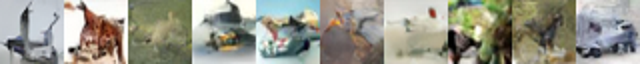

Generation of 10 new images for t=0.9


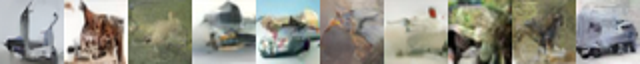

Generation of 10 new images for t=0.8


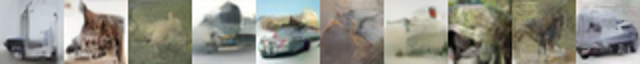

In [37]:
for t in temperatures[: H.num_temperatures_visualize]:
    print("=" * 25)
    print(f"Generation of {n_images} new images for t={t}")
    print("=" * 25)
    fname = f"{H.save_dir}/generations-tem-{t}.png"
    display(Image.open(fname))

## Reconstructions

In [38]:
n_images = 10
image_shape = [H.image_size, H.image_size, H.image_channels]

Preprocessing images before getting the latents

In [39]:
from train import get_sample_for_visualization

viz_batch_original, viz_batch_processed = get_sample_for_visualization(
    data_valid_or_test, preprocess_fn, n_images, H.dataset
)

Getting the partial functions from the model methods

In [40]:
forward_get_latents = partial(ema_apply, method=VAE(H).forward_get_latents)
forward_samples_set_latents = partial(ema_apply, method=VAE(H).forward_samples_set_latents)

Getting latents of different levels.

In [41]:
zs = [s["z"] for s in forward_get_latents(viz_batch_processed, rng)]

No of latent observations used depends on `H.num_variables_visualize `, altering it gives different resolutions of the reconstructions.

In [42]:
recons = []
lv_points = np.floor(np.linspace(0, 1, H.num_variables_visualize + 2) * len(zs)).astype(int)[1:-1]
for i in lv_points:
    recons.append(forward_samples_set_latents(n_images, zs[:i], rng, t=0.1))

Original Images

Original test images
printing samples to ./saved_models/test/orig_test.png


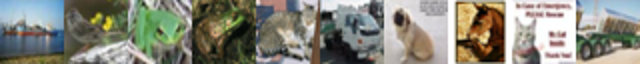

In [43]:
orig_im = np.array(viz_batch_original)
print("Original test images")
save_n_show(orig_im, [1, n_images], image_shape, f"{H.save_dir}/orig_test.png", show=True)

Reconstructions.

Generation of 10 new images for 1x resolution
printing samples to ./saved_models/test/recon_test-res-1x.png


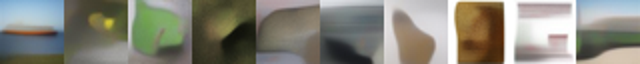

Generation of 10 new images for 2x resolution
printing samples to ./saved_models/test/recon_test-res-2x.png


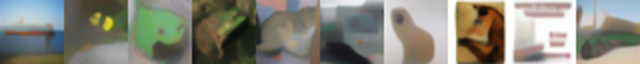

Generation of 10 new images for 3x resolution
printing samples to ./saved_models/test/recon_test-res-3x.png


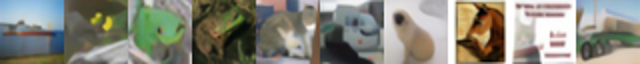

Generation of 10 new images for 4x resolution
printing samples to ./saved_models/test/recon_test-res-4x.png


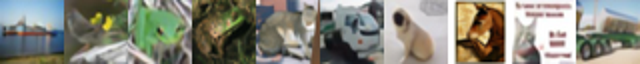

Generation of 10 new images for 5x resolution
printing samples to ./saved_models/test/recon_test-res-5x.png


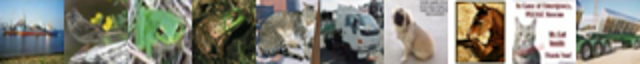

Generation of 10 new images for 6x resolution
printing samples to ./saved_models/test/recon_test-res-6x.png


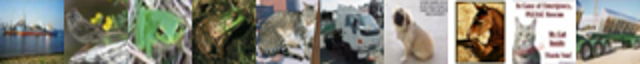

In [44]:
for i, r in enumerate(recons):
    r = np.array(r)
    print("=" * 25)
    print(f"Generation of {n_images} new images for {i+1}x resolution")
    print("=" * 25)
    fname = f"{H.save_dir}/recon_test-res-{i+1}x.png"
    save_n_show(r, [1, n_images], image_shape, fname, show=True)